In [1]:
import os
import pyspark
from pyspark.sql import SparkSession
import findspark
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, unix_timestamp, dayofweek, dayofmonth, udf, hour, minute, unix_timestamp, concat_ws
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.appName("Predict price") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 09:30:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Relative path
rel_path = "../TOMAS/projeto_principal/full_dataset_after_cleaning.parquet"

# Get absolute path
abs_path = os.path.abspath(rel_path)

# Load the dataset
data = spark.read.parquet(abs_path)

In [4]:
print(data.count())
data.printSchema()

21345357
root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- pickup_hour_decimal: double (nullabl

In [5]:
# Extract day of week
df = data.withColumn("day", dayofmonth("tpep_pickup_datetime")) \
    .withColumn("hour", hour("tpep_pickup_datetime")) \
    .withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
    .withColumn("PULocationID", col("PULocationID").cast("int")) \
    .withColumn("DOLocationID", col("DOLocationID").cast("int"))

df = df.select(["trip_distance", 
               "total_amount", 
               "PULocationID",
               "DOLocationID",
               "is_holiday", 
               "is_weekend", 
               "month", 
            #    "day",
               "day_of_week",
               "hour", 
            #    "passenger_count",
               "is_shared_ride",
               "Airport_fee",
               "tolls_amount",
               "congestion_surcharge"])

df.show(5)

+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+------------+--------------------+
|trip_distance|total_amount|PULocationID|DOLocationID|is_holiday|is_weekend|month|day_of_week|hour|is_shared_ride|Airport_fee|tolls_amount|congestion_surcharge|
+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+------------+--------------------+
|          0.6|        12.1|         100|          48|         0|         0|    8|          4|   2|             0|          0|         0.0|                 2.5|
|          8.5|       61.84|         262|         138|         0|         0|    7|          3|  17|             1|          0|        6.94|                 2.5|
|         4.16|        31.8|         140|         114|         0|         0|    7|          6|  17|             1|          0|         0.0|                 2.5|
|          2.0|        27.2|      

In [6]:
number_of_nulls = df.filter(
    reduce(lambda x, y: x | y, [col(c).isNull() for c in df.columns])
).count()
print(number_of_nulls)
df = df.dropna()

11604


In [7]:
print(data.groupBy('has_congestion_fee').avg("total_amount").orderBy('has_congestion_fee').show())
print(data.groupBy('has_toll').avg("total_amount").orderBy('has_toll').show())

+------------------+------------------+
|has_congestion_fee| avg(total_amount)|
+------------------+------------------+
|                 0| 54.74656351917642|
|                 1|27.567723767124548|
+------------------+------------------+

None
+--------+-----------------+
|has_toll|avg(total_amount)|
+--------+-----------------+
|       0|24.63425585624891|
|       1|77.98367788301722|
+--------+-----------------+

None


In [55]:
for feature in df.columns[2:11]:
    df.groupBy(feature).avg("total_amount").orderBy(feature).show()

+------------+------------------+
|PULocationID| avg(total_amount)|
+------------+------------------+
|           1| 71.89585106382978|
|           3|36.638400000000004|
|           4|23.921157870791617|
|           7|25.346067045246382|
|          10|  77.5481673441734|
|          12|34.404836276083465|
|          13| 33.62789338740498|
|          14|33.855802047781566|
|          17| 22.51288209606987|
|          18|24.900125000000003|
|          20|31.408974358974366|
|          21| 42.58694444444444|
|          22|28.008611111111108|
|          24|23.270833993436707|
|          25| 26.72514628947878|
|          26|30.380107526881716|
|          28| 57.09739316239317|
|          29| 41.30253731343284|
|          32| 33.20636363636363|
|          33| 30.23103744292237|
+------------+------------------+
only showing top 20 rows



+------------+------------------+
|DOLocationID| avg(total_amount)|
+------------+------------------+
|           1|134.19796660645397|
|           3|  78.0919945355191|
|           4|24.787435267857123|
|           6|100.31222482435595|
|           7| 38.18930228953202|
|           9| 57.05064883995282|
|          10|31.446331621423326|
|          11| 78.54985985160756|
|          12|30.198114653167327|
|          13|34.162225894485644|
|          14|  77.2376066161817|
|          15| 60.29449692656099|
|          16| 63.50367397693874|
|          17|53.128868746321395|
|          18| 71.16865191986646|
|          19|55.657488721804526|
|          20| 73.16530963920302|
|          21| 77.69071923281834|
|          22| 77.71600395647872|
|          24|27.669790612988127|
+------------+------------------+
only showing top 20 rows



+----------+------------------+
|is_holiday| avg(total_amount)|
+----------+------------------+
|         0|29.164424278419478|
|         1|30.476573017499447|
+----------+------------------+



+----------+------------------+
|is_weekend| avg(total_amount)|
+----------+------------------+
|         0|29.575819943474215|
|         1| 27.84385984687093|
+----------+------------------+



+-----+------------------+
|month| avg(total_amount)|
+-----+------------------+
|    1|27.812824356254207|
|    2|27.811076687897547|
|    3|28.560358475557322|
|    4|28.839414360448696|
|    5|29.558306741368806|
|    6|29.335225810502624|
|    7|29.560853297585343|
|    8|29.644068851160075|
|    9|30.101182766615263|
|   10|  29.8383510282898|
|   11|29.009112606191955|
|   12| 29.85962517174841|
+-----+------------------+



+-----------+------------------+
|day_of_week| avg(total_amount)|
+-----------+------------------+
|          1| 29.53764154356986|
|          2|30.703328083316134|
|          3| 29.31400825343334|
|          4|29.380651955765877|
|          5|29.810460764377765|
|          6| 28.89192919930456|
|          7|26.445783623454265|
+-----------+------------------+



+----+------------------+
|hour| avg(total_amount)|
+----+------------------+
|   0| 26.89349131525526|
|   1|24.653252689283292|
|   2|23.553106162068794|
|   3|24.309049946637437|
|   4| 29.35623936063946|
|   5| 32.31145452583344|
|   6|31.574119300187203|
|   7|30.639486765224603|
|   8|31.097384169146892|
|   9|32.854211253897375|
|  10| 34.02164525124956|
|  11| 33.33518969418832|
|  12| 33.70801077275955|
|  13|34.188388634422125|
|  14| 35.40810413544089|
|  15| 34.75755638973954|
|  16| 32.79036613663388|
|  17|30.370672371655242|
|  18| 28.77897502315753|
|  19|28.939364107048217|
+----+------------------+
only showing top 20 rows



+--------------+------------------+
|is_shared_ride| avg(total_amount)|
+--------------+------------------+
|             0|28.817681784694226|
|             1|30.608725399757073|
+--------------+------------------+



+-----------+------------------+
|Airport_fee| avg(total_amount)|
+-----------+------------------+
|          0|24.429168791970373|
|          1| 71.11676635438688|
+-----------+------------------+



Include: 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'

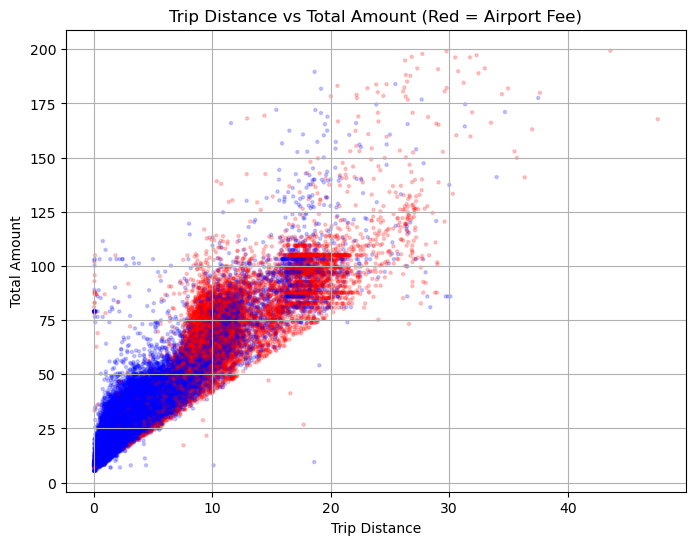

In [8]:
# Select the data including Airport_fee
pandas_df = df.select(["trip_distance", "total_amount", "Airport_fee"]) \
              .limit(100000).toPandas()

# Define colors: red if Airport_fee == 1, else blue
colors = pandas_df['Airport_fee'].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title("Trip Distance vs Total Amount (Red = Airport Fee)")
plt.grid(True)
plt.show()

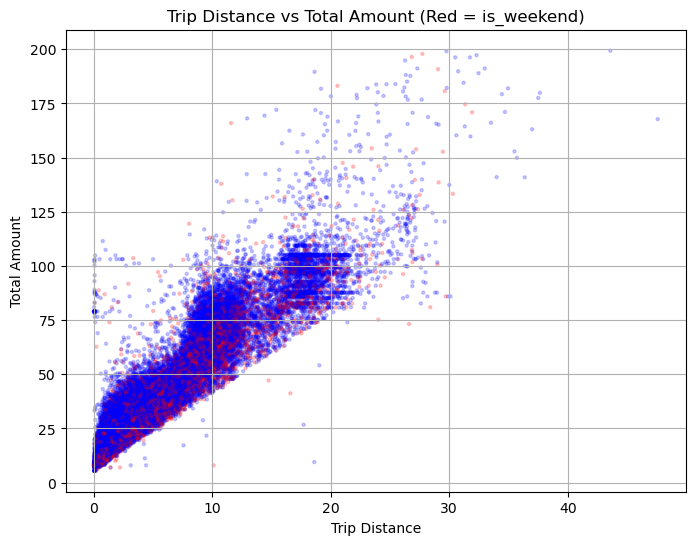

In [10]:
feature = 'is_weekend' #'is_holiday' #'is_shared_ride' 
pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

# Define colors: red if col == 1, else blue
colors = pandas_df[feature].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount (Red = {feature})")
plt.grid(True)
plt.show()

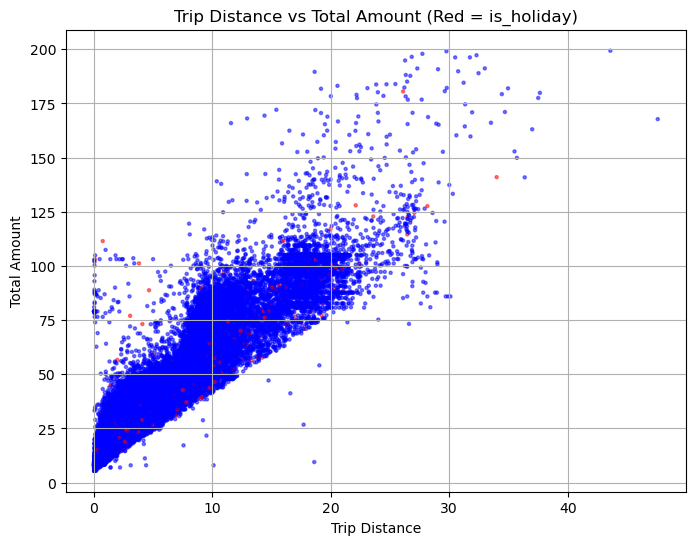

In [12]:
feature = 'is_holiday' #'is_shared_ride' 
pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

# Define colors: red if col == 1, else blue
colors = pandas_df[feature].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.5, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount (Red = {feature})")
plt.grid(True)
plt.show()

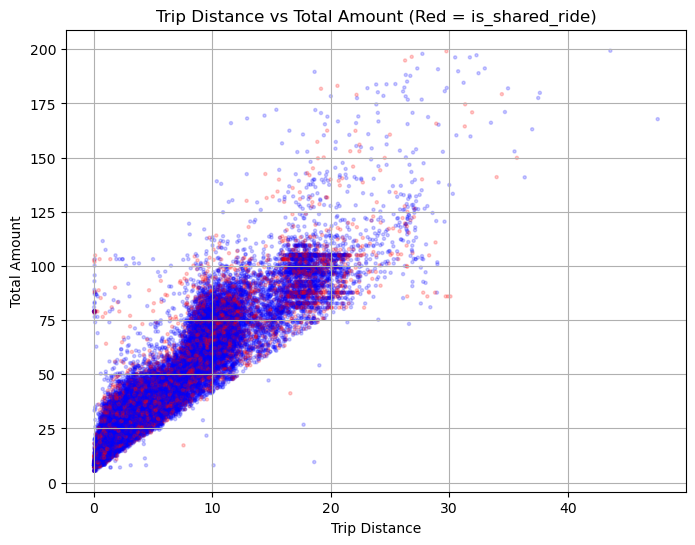

In [13]:
feature = 'is_shared_ride' 
pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

# Define colors: red if col == 1, else blue
colors = pandas_df[feature].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount (Red = {feature})")
plt.grid(True)
plt.show()

/var/folders/s7/s9wfpwyx2dj_9c9q_c07v03w0000gn/T/ipykernel_39048/2493684652.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('hsv', pandas_df.PULocationID.nunique()),


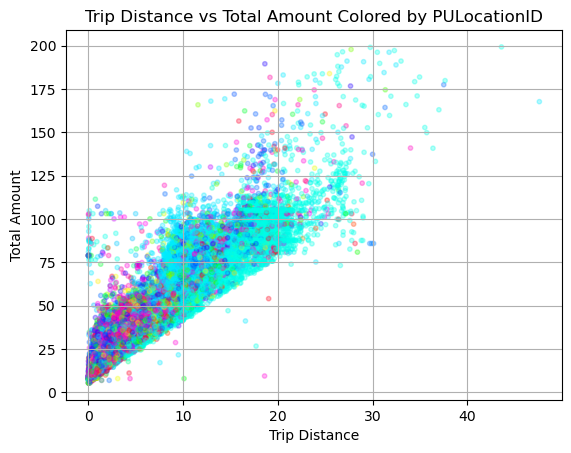

In [25]:
# Scatter plot, color by col
feature ='PULocationID'

pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

scatter = plt.scatter(
    pandas_df['trip_distance'],
    pandas_df['total_amount'],
    c=pandas_df[feature],
    cmap=plt.cm.get_cmap('hsv', pandas_df.PULocationID.nunique()), 
    alpha=0.3,
    s=10
)

plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount Colored by {feature}")
plt.grid(True)

plt.show()

/var/folders/s7/s9wfpwyx2dj_9c9q_c07v03w0000gn/T/ipykernel_39048/1360684285.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 24)


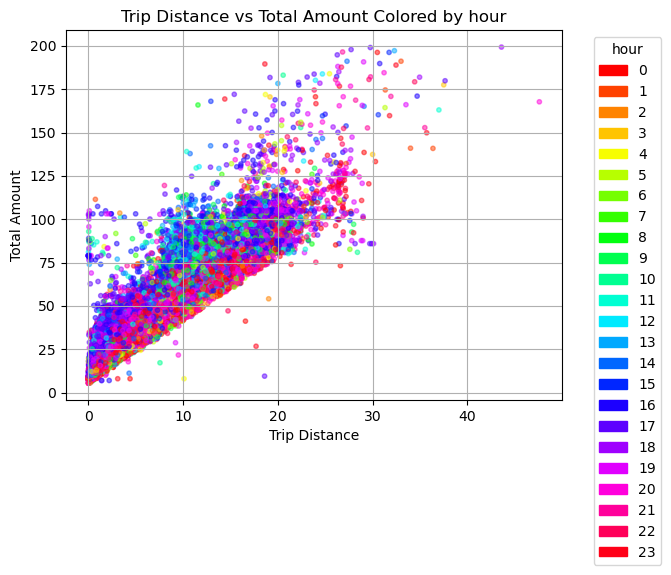

In [ ]:
import matplotlib.patches as mpatches

# Scatter plot, color by col
feature = 'hour'

# Get unique values and corresponding colors
cmap = plt.cm.get_cmap('hsv', 24)
color_map = {hour: cmap(hour) for hour in range(24)}

pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

scatter = plt.scatter(
    pandas_df['trip_distance'],
    pandas_df['total_amount'],
    c = pandas_df[feature].map(color_map),
    alpha=0.5,
    s=10
)

plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount Colored by {feature}")
plt.grid(True)

# Add legend 
handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=handles, title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [7]:
# no need for indexer as all values doubles or integers
df.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- is_shared_ride: integer (nullable = true)
 |-- Airport_fee: integer (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [103]:
df.groupBy(df.columns).count().filter("count > 1").show()

25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:52 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+-----+
|trip_distance|total_amount|PULocationID|DOLocationID|is_holiday|is_weekend|month|day_of_week|hour|is_shared_ride|Airport_fee|count|
+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+-----+
|         0.01|         5.5|         264|         264|         0|         1|    1|          1|   1|             0|          0|    2|
|         0.01|         7.0|         193|         193|         0|         0|    5|          3|  16|             0|          0|    4|
|         0.01|        7.25|         132|         132|         0|         0|    2|          2|  22|             0|          1|    2|
|         0.01|        7.25|         132|         132|         0|         0|    2|          2|  22|             1|          1|    2|
|         0.01|        7.25|         132|         132|         0|    

In [8]:
features = ['trip_distance']
features2 = ['trip_distance', "tolls_amount", "congestion_surcharge"]
features3 = ['trip_distance',
    #'is_holiday',
    #'is_weekend',
    #'month',
    'PULocationID',
    'DOLocationID',
    #'day_of_week',
    'hour',
    #'is_shared_ride',
    'Airport_fee',
    "tolls_amount",
    "congestion_surcharge"]
features4 = ['trip_distance',
    #'is_holiday',
    #'is_weekend',
    #'month',
    'PULocationID',
    'DOLocationID',
    'day_of_week',
    'hour',
    'is_shared_ride',
    'Airport_fee',
    #"tolls_amount",
    #"congestion_surcharge"
    ]
features5 = ['trip_distance',
    #'is_holiday',
    #'is_weekend',
    #'month',
    'PULocationID',
    'DOLocationID',
    'day_of_week',
    'hour',
    'is_shared_ride',
    'Airport_fee',
    "tolls_amount",
    "congestion_surcharge"]

assembler = VectorAssembler(inputCols=features,
outputCol='features')

assembler2 = VectorAssembler(inputCols=features2, 
outputCol='features2')

assembler3 = VectorAssembler(inputCols=features3, 
outputCol='features3')

assembler4 = VectorAssembler(inputCols=features4, 
outputCol='features4')

assembler5 = VectorAssembler(inputCols=features5, 
outputCol='features5')

df = assembler.transform(df)
df = assembler2.transform(df)
df = assembler3.transform(df)
df = assembler4.transform(df)
df = assembler5.transform(df)

In [9]:
# Split data
train_data, val_data, test_data = df.select(['features', 'features2', 'features3', 'features4', 'features5', 'total_amount']).randomSplit([0.6, 0.2, 0.2], seed=42)
train_data.show(5, truncate=False)

+--------+--------------+---------------------------------+----------------------------------+-----------------------------------------+------------+
|features|features2     |features3                        |features4                         |features5                                |total_amount|
+--------+--------------+---------------------------------+----------------------------------+-----------------------------------------+------------+
|[0.01]  |[0.01,0.0,0.0]|(7,[0,1,2],[0.01,132.0,132.0])   |[0.01,132.0,132.0,3.0,0.0,0.0,0.0]|(9,[0,1,2,3],[0.01,132.0,132.0,3.0])     |5.5         |
|[0.01]  |[0.01,0.0,0.0]|[0.01,10.0,10.0,17.0,0.0,0.0,0.0]|[0.01,10.0,10.0,4.0,17.0,0.0,0.0] |[0.01,10.0,10.0,4.0,17.0,0.0,0.0,0.0,0.0]|7.0         |
|[0.01]  |[0.01,0.0,0.0]|[0.01,24.0,24.0,22.0,0.0,0.0,0.0]|[0.01,24.0,24.0,5.0,22.0,0.0,0.0] |[0.01,24.0,24.0,5.0,22.0,0.0,0.0,0.0,0.0]|30.0        |
|[0.01]  |[0.01,0.0,0.0]|[0.01,26.0,26.0,3.0,0.0,0.0,0.0] |[0.01,26.0,26.0,6.0,3.0,0.0,0.0]  |[0.01,

In [12]:
train_data.count()

12802879

In [13]:
val_data.count()

4263221

In [11]:
test_data.count()

4267653

In [ ]:
# Define Linear Regression model # 6.9
lr = LinearRegression(featuresCol="features", labelCol="total_amount")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
predictions.select("features", "total_amount", "prediction").show(10)

# Model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

25/05/09 08:56:30 WARN Instrumentation: [775b4510] regParam is zero, which might cause numerical instability and overfitting.
25/05/09 08:56:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/09 08:57:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 6.901763931978128
R^2: 0.8915476522066901
MAE: 4.317397993246555


+--------+------------+------------------+
|features|total_amount|        prediction|
+--------+------------+------------------+
|  [0.01]|         5.5|12.812818838522267|
|  [0.01]|         7.0|12.812818838522267|
|  [0.01]|         7.7|12.812818838522267|
|  [0.01]|        13.9|12.812818838522267|
|  [0.01]|        12.0|12.812818838522267|
|  [0.01]|        25.0|12.812818838522267|
|  [0.01]|       11.25|12.812818838522267|
|  [0.01]|         7.0|12.812818838522267|
|  [0.01]|         5.5|12.812818838522267|
|  [0.01]|         5.5|12.812818838522267|
+--------+------------+------------------+
only showing top 10 rows

Coefficients: [4.903417204514874]
Intercept: 12.763784666477118


In [15]:
# Define Linear Regression model # 6.21
lr = LinearRegression(featuresCol="features2", labelCol="total_amount")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")
predictions.select("features2", "total_amount", "prediction").show(10)

# Model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

25/05/09 09:02:14 WARN Instrumentation: [fbc6d6fc] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE): 6.208538570986386
R^2: 0.9122398162189559
MAE: 3.983653897577948


+--------------+------------+------------------+
|     features2|total_amount|        prediction|
+--------------+------------+------------------+
|[0.01,0.0,0.0]|         5.5|11.629562352025614|
|[0.01,0.0,0.0]|         7.0|11.629562352025614|
|[0.01,0.0,0.0]|         7.7|11.629562352025614|
|[0.01,0.0,0.0]|        13.9|11.629562352025614|
|[0.01,0.0,0.0]|        12.0|11.629562352025614|
|[0.01,0.0,0.0]|        25.0|11.629562352025614|
|[0.01,0.0,0.0]|       11.25|11.629562352025614|
|[0.01,0.0,0.0]|         7.0|11.629562352025614|
|[0.01,0.0,0.0]|         5.5|11.629562352025614|
|[0.01,0.0,0.0]|         5.5|11.629562352025614|
+--------------+------------+------------------+
only showing top 10 rows

Coefficients: [4.348272351948462,1.8167169243766854,0.8170917500293327]
Intercept: 11.586079628506129


In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount") #6.76

# Train
model = rf.fit(train_data)

# Predict
predictions = model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")

importances = model.featureImportances
print(features)
importances

RMSE: 6.662567305028118
R^2: 0.8989347218701603
MAE: 4.095107630033353
['trip_distance']


SparseVector(1, {0: 1.0})

In [12]:
rf = RandomForestRegressor(featuresCol="features2", labelCol="total_amount") 

# Train
model = rf.fit(train_data)

# Predict
predictions = model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")

importances = model.featureImportances
print(features2)
importances

25/05/09 09:50:41 WARN MemoryStore: Not enough space to cache rdd_122_0 in memory! (computed 17.8 MiB so far)
25/05/09 09:50:41 WARN BlockManager: Persisting block rdd_122_0 to disk instead.
25/05/09 09:50:41 WARN MemoryStore: Not enough space to cache rdd_122_6 in memory! (computed 17.8 MiB so far)
25/05/09 09:50:41 WARN BlockManager: Persisting block rdd_122_6 to disk instead.
25/05/09 09:50:41 WARN MemoryStore: Not enough space to cache rdd_122_5 in memory! (computed 17.8 MiB so far)
25/05/09 09:50:41 WARN BlockManager: Persisting block rdd_122_5 to disk instead.
25/05/09 09:50:41 WARN MemoryStore: Not enough space to cache rdd_122_2 in memory! (computed 17.8 MiB so far)
25/05/09 09:50:41 WARN BlockManager: Persisting block rdd_122_2 to disk instead.
25/05/09 09:50:41 WARN MemoryStore: Not enough space to cache rdd_122_1 in memory! (computed 17.8 MiB so far)
25/05/09 09:50:41 WARN BlockManager: Persisting block rdd_122_1 to disk instead.
25/05/09 09:50:43 WARN MemoryStore: Not enoug

RMSE: 7.6569582669302445
R^2: 0.8665153530953524
MAE: 5.300072975862421
['trip_distance', 'tolls_amount', 'congestion_surcharge']


SparseVector(3, {0: 0.6081, 1: 0.3491, 2: 0.0428})

In [13]:
rf = RandomForestRegressor(featuresCol="features3", labelCol="total_amount") 

# Train
model = rf.fit(train_data)

# Predict
predictions = model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")

importances = model.featureImportances
print(features3)
importances

25/05/09 09:56:03 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 12.5 MiB so far)
25/05/09 09:56:03 WARN BlockManager: Persisting block rdd_189_1 to disk instead.
25/05/09 09:56:03 WARN MemoryStore: Not enough space to cache rdd_189_4 in memory! (computed 19.2 MiB so far)
25/05/09 09:56:03 WARN BlockManager: Persisting block rdd_189_4 to disk instead.
25/05/09 09:56:03 WARN MemoryStore: Not enough space to cache rdd_189_0 in memory! (computed 19.2 MiB so far)
25/05/09 09:56:03 WARN BlockManager: Persisting block rdd_189_0 to disk instead.
25/05/09 09:56:04 WARN MemoryStore: Not enough space to cache rdd_189_7 in memory! (computed 19.2 MiB so far)
25/05/09 09:56:04 WARN BlockManager: Persisting block rdd_189_7 to disk instead.
25/05/09 09:56:04 WARN MemoryStore: Not enough space to cache rdd_189_5 in memory! (computed 19.2 MiB so far)
25/05/09 09:56:04 WARN BlockManager: Persisting block rdd_189_5 to disk instead.
25/05/09 09:56:05 WARN MemoryStore: Not enoug

RMSE: 6.422034531740836
R^2: 0.9061003378084036
MAE: 4.398919608280725
['trip_distance', 'PULocationID', 'DOLocationID', 'hour', 'Airport_fee', 'tolls_amount', 'congestion_surcharge']


SparseVector(7, {0: 0.7018, 1: 0.0167, 2: 0.0092, 3: 0.0025, 4: 0.118, 5: 0.1386, 6: 0.0131})

In [14]:
rf = RandomForestRegressor(featuresCol="features4", labelCol="total_amount") 

# Train
model = rf.fit(train_data)

# Predict
predictions = model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")

importances = model.featureImportances
print(features4)
importances

25/05/09 10:00:30 WARN MemoryStore: Not enough space to cache rdd_256_3 in memory! (computed 29.6 MiB so far)
25/05/09 10:00:30 WARN BlockManager: Persisting block rdd_256_3 to disk instead.
25/05/09 10:00:30 WARN MemoryStore: Not enough space to cache rdd_256_5 in memory! (computed 5.5 MiB so far)
25/05/09 10:00:30 WARN BlockManager: Persisting block rdd_256_5 to disk instead.
25/05/09 10:00:30 WARN MemoryStore: Not enough space to cache rdd_256_6 in memory! (computed 5.5 MiB so far)
25/05/09 10:00:30 WARN BlockManager: Persisting block rdd_256_6 to disk instead.
25/05/09 10:00:30 WARN MemoryStore: Not enough space to cache rdd_256_7 in memory! (computed 12.5 MiB so far)
25/05/09 10:00:30 WARN BlockManager: Persisting block rdd_256_7 to disk instead.
25/05/09 10:00:30 WARN MemoryStore: Not enough space to cache rdd_256_2 in memory! (computed 29.6 MiB so far)
25/05/09 10:00:30 WARN BlockManager: Persisting block rdd_256_2 to disk instead.
25/05/09 10:00:30 WARN MemoryStore: Not enough 

RMSE: 7.128674313452043
R^2: 0.8842992153591688
MAE: 4.796749555245086
['trip_distance', 'PULocationID', 'DOLocationID', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee']


SparseVector(7, {0: 0.7742, 1: 0.0054, 2: 0.0281, 3: 0.0003, 4: 0.0057, 5: 0.0, 6: 0.1863})

In [15]:
rf = RandomForestRegressor(featuresCol="features5", labelCol="total_amount") 

# Train
model = rf.fit(train_data)

# Predict
predictions = model.transform(val_data)

# Evaluate model
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Show results
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAE: {mae}")

importances = model.featureImportances
print(features5)
importances

25/05/09 10:05:14 WARN MemoryStore: Not enough space to cache rdd_323_5 in memory! (computed 18.0 MiB so far)
25/05/09 10:05:14 WARN BlockManager: Persisting block rdd_323_5 to disk instead.
25/05/09 10:05:14 WARN MemoryStore: Not enough space to cache rdd_323_4 in memory! (computed 18.0 MiB so far)
25/05/09 10:05:14 WARN BlockManager: Persisting block rdd_323_4 to disk instead.
25/05/09 10:05:15 WARN MemoryStore: Not enough space to cache rdd_323_1 in memory! (computed 11.7 MiB so far)
25/05/09 10:05:15 WARN BlockManager: Persisting block rdd_323_1 to disk instead.
25/05/09 10:05:15 WARN MemoryStore: Not enough space to cache rdd_323_7 in memory! (computed 11.7 MiB so far)
25/05/09 10:05:15 WARN BlockManager: Persisting block rdd_323_7 to disk instead.
25/05/09 10:05:15 WARN MemoryStore: Not enough space to cache rdd_323_0 in memory! (computed 27.1 MiB so far)
25/05/09 10:05:15 WARN BlockManager: Persisting block rdd_323_0 to disk instead.
25/05/09 10:05:15 WARN MemoryStore: Not enoug

RMSE: 7.359492320290111
R^2: 0.8766854081503659
MAE: 5.189811520458111
['trip_distance', 'PULocationID', 'DOLocationID', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee', 'tolls_amount', 'congestion_surcharge']


SparseVector(9, {0: 0.5195, 1: 0.0096, 2: 0.016, 3: 0.0005, 4: 0.0025, 5: 0.0, 6: 0.1458, 7: 0.2829, 8: 0.0233})

## Old

In [48]:
# Predict with pu, do locations + 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 6.94


In [ ]:
# Extract feature importances
# 'trip_distance', pu, do, 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
importances = model2.featureImportances
importances

SparseVector(7, {0: 0.6591, 1: 0.024, 2: 0.0155, 3: 0.0002, 4: 0.0063, 5: 0.0, 6: 0.295})

In [ ]:
# Predict with 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.69


In [23]:
# Extract feature importances
# 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
importances = model2.featureImportances
importances

SparseVector(5, {0: 0.6799, 1: 0.0018, 2: 0.012, 3: 0.0002, 4: 0.3061})

In [ ]:
# Predict with many features
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.85


In [78]:
rf = RandomForestRegressor(featuresCol="features2", labelCol="total_amount")

# Train
model = rf.fit(train_data)

# Predict
predictions = model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.2f}")

importances = model.featureImportances
importances

25/05/08 12:21:24 WARN MemoryStore: Not enough space to cache rdd_581_7 in memory! (computed 5.1 MiB so far)
25/05/08 12:21:24 WARN BlockManager: Persisting block rdd_581_7 to disk instead.
25/05/08 12:21:24 WARN MemoryStore: Not enough space to cache rdd_581_4 in memory! (computed 5.1 MiB so far)
25/05/08 12:21:24 WARN BlockManager: Persisting block rdd_581_4 to disk instead.
25/05/08 12:21:24 WARN MemoryStore: Not enough space to cache rdd_581_1 in memory! (computed 5.1 MiB so far)
25/05/08 12:21:24 WARN BlockManager: Persisting block rdd_581_1 to disk instead.
25/05/08 12:21:24 WARN MemoryStore: Not enough space to cache rdd_581_0 in memory! (computed 5.1 MiB so far)
25/05/08 12:21:24 WARN BlockManager: Persisting block rdd_581_0 to disk instead.
25/05/08 12:21:24 WARN MemoryStore: Not enough space to cache rdd_581_3 in memory! (computed 5.1 MiB so far)
25/05/08 12:21:24 WARN BlockManager: Persisting block rdd_581_3 to disk instead.
25/05/08 12:21:24 WARN MemoryStore: Not enough spa

RMSE: 7.23


SparseVector(9, {0: 0.4414, 1: 0.0141, 2: 0.0151, 3: 0.0003, 4: 0.0043, 5: 0.0, 6: 0.3087, 7: 0.2018, 8: 0.0144})

In [ ]:
# 'trip_distance', 'PULocationID', 'DOLocationID', 'day_of_week', 'hour', 
# 'is_shared_ride', 'Airport_fee', "tolls_amount", "congestion_surcharge"